In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor

In [ ]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

## 데이터 전처리

### 결측치 처리

**1. 수치형 변수**
- `LotFrontage`: 도로에 접한 토지 길이 (피트 단위)
- `MasVnrArea` : 석조 베니어 면적 (평방 피트)
- `GarageYrBlt` : 차고 건축 연도

**2. 범주형 변수**
- `PoolQC` : 수영장 품질
- `MiscFeature`	: 기타 특수 기능
-	`Fence` : 울타리 품질
-	`MasVnrType`  :	석조 베니어 타입
-	`Alley` :	골목 접근 방식
-	`FireplaceQu` :	벽난로 품질
-	`GarageType` :	차고 위치(유형)
-	`GarageFinish` :	차고 내부 마감 상태
-	`GarageQual` :	차고 품질
-	`BsmtExposure` :	지하실 외부 노출 여부
-	`GarageCond` :	차고 상태
-	`BsmtFinType2` :	보조 지하실 마감 구역 유형
-	`BsmtQual` :	지하실 높이 평가
-	`BsmtCond` :	지하실 상태 평가
-	`BsmtFinType1` :	주요 지하실 마감 구역 유형
-	`Electrical` :	전기 시스템 종류

##  전체 컬럼 중 결측치를 보유한 컬럼의 결측치 개수 확인

In [ ]:
train_df.select_dtypes(include='number').describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1168.000000,1168.00000,950.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1160.000000,1168.000000,...,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000
mean,728.528253,56.97774,70.058947,10336.357877,6.105308,5.595890,1971.201199,1985.021404,102.938793,442.928938,...,90.971747,47.554795,22.715753,3.219178,16.332192,2.955479,51.279110,6.306507,2007.830479,180194.401541
std,415.393477,42.29068,24.762405,8784.854640,1.373032,1.127388,30.362445,20.693264,176.142597,462.364719,...,123.811685,68.250085,63.042971,29.241246,58.828037,41.648504,552.357575,2.715955,1.323583,78869.201529
min,1.000000,20.00000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,373.750000,20.00000,59.000000,7560.000000,5.000000,5.000000,1954.000000,1966.750000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129500.000000
50%,720.500000,50.00000,69.000000,9446.000000,6.000000,5.000000,1972.500000,1994.000000,0.000000,374.500000,...,0.000000,25.500000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163995.000000
75%,1086.250000,70.00000,80.000000,11601.500000,7.000000,6.000000,2001.000000,2004.000000,168.000000,714.500000,...,165.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,213062.500000
max,1460.000000,190.00000,313.000000,164660.000000,10.000000,9.000000,2010.000000,2010.000000,1170.000000,5644.000000,...,736.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [ ]:
# 범주형 컬럼
target_cate_cols = [
    'Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
    'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu',
    'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
    'PoolQC', 'Fence', 'MiscFeature'
]

# 수치형 컬럼
target_num_cols = ['LotFrontage', 'MasVnrArea', 'GarageYrBlt']

# 범주형 컬럼 먼저 확인
missing_counts1 = train_df[target_cate_cols].isnull().sum()

sorted_missing = missing_counts1.sort_values(ascending=False)

print(sorted_missing)

PoolQC          1162
MiscFeature     1120
Alley           1098
Fence            941
MasVnrType       694
FireplaceQu      545
GarageFinish      69
GarageQual        69
GarageType        69
GarageCond        69
BsmtExposure      24
BsmtFinType2      24
BsmtQual          23
BsmtFinType1      23
BsmtCond          23
Electrical         1
dtype: int64


In [ ]:
# 수치형 컬럼 확인
missing_counts2 = train_df[target_num_cols].isnull().sum()

sorted_missing = missing_counts2.sort_values(ascending=False)

print(sorted_missing)

LotFrontage    218
GarageYrBlt     69
MasVnrArea       8
dtype: int64


In [ ]:
# 수치형 컬럼 정보 확인용

null_counts = train_df.isnull().sum()
cols_with_null = null_counts[null_counts > 0].index

df_missing = train_df[cols_with_null]

df_missing.select_dtypes(include='number').describe()

,LotFrontage,MasVnrArea,GarageYrBlt
count,950.000000,1160.000000,1099.000000
mean,70.058947,102.938793,1978.404914
std,24.762405,176.142597,24.988391
min,21.000000,0.000000,1908.000000
25%,59.000000,0.000000,1962.000000
50%,69.000000,0.000000,1980.000000
75%,80.000000,168.000000,2002.000000
max,313.000000,1170.000000,2010.000000


In [ ]:
### 수치형 데이터 컬럼 결측치 처리

# LotFrontage -> 같은 동네 별 중앙값으로 채우기
train_df['LotFrontage'] = train_df.groupby('Neighborhood')['LotFrontage'].transform(lambda x : x.fillna(x.median()))
train_df['LotFrontage'] = train_df['LotFrontage'].fillna(train_df['LotFrontage'].median())

# MasVnrArea , GarageYrBlt -> 없는 옵션 = 0으로 채우기
train_df['MasVnrArea'] = train_df['MasVnrArea'].fillna(0)
train_df['GarageYrBlt'] = train_df['GarageYrBlt'].fillna(0)

print("처리 후 남은 수치형 결측치 개수:", train_df.select_dtypes(include=['number']).isnull().sum().sum())

처리 후 남은 수치형 결측치 개수: 0


In [ ]:
### 범주형 데이터 컬럼 결측치 처리

# 시설 자체를 보유하지 않은 경우 'None'으로 대체

none_cols = [
    'Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
    'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu',
    'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
    'PoolQC', 'Fence', 'MiscFeature'
]

for col in none_cols:
  train_df[col] = train_df[col].fillna('None')

# Electrical은 결측치 1개 -> 최빈값으로 대체

train_df['Electrical'] = train_df['Electrical'].fillna(train_df['Electrical'].mode()[0])

print("처리 후 범주형 결측치 개수 : ", train_df.select_dtypes(include=['object']).isnull().sum().sum())

처리 후 범주형 결측치 개수 :  0


## 훈련에 사용할 타겟(`SalesPrice`)를 로그 변환

- 로그 변환을 통해 회귀에 알맞은 정규분포꼴 형성
- 안정적인 예측을 기대
- 테스트 시 로그 변환 초기화 필수!!

Original Skewness: 1.9578
Original Kurtosis: 7.4059
Log Transformed Skewness: 0.0862
Log Transformed Kurtosis: 0.8758


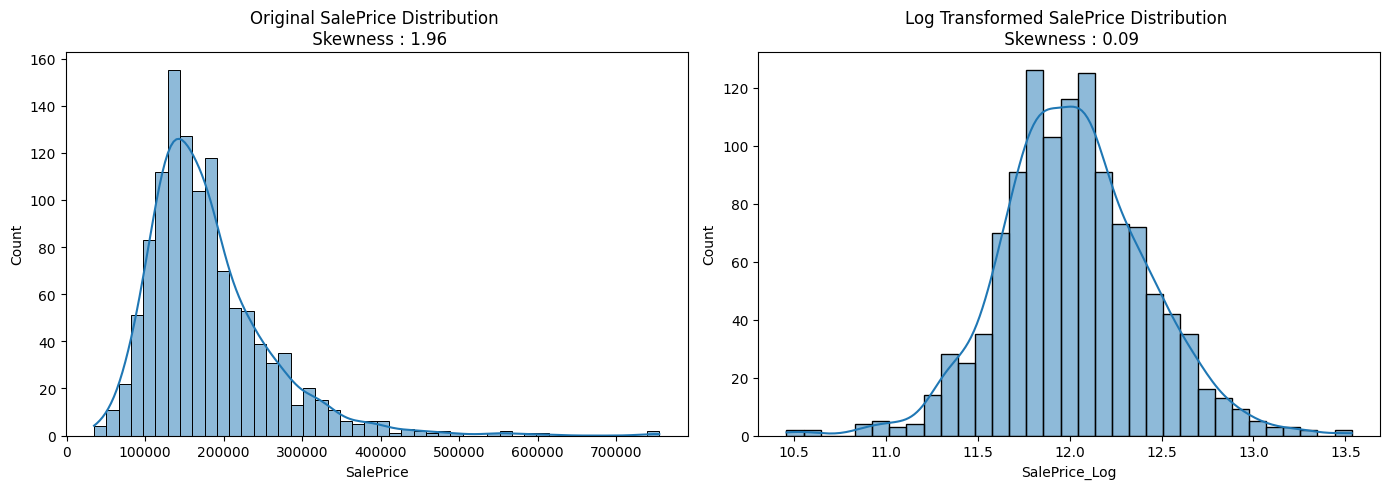

In [ ]:
### SalesPrice 로그 스케일링

original_skew = train_df['SalePrice'].skew()
original_kurt = train_df['SalePrice'].kurt()

train_df['SalePrice_Log'] = np.log1p(train_df['SalePrice'])

log_skew = train_df['SalePrice_Log'].skew()
log_kurt = train_df['SalePrice_Log'].kurt()

print(f"Original Skewness: {original_skew:.4f}")
print(f"Original Kurtosis: {original_kurt:.4f}")
print(f"Log Transformed Skewness: {log_skew:.4f}")
print(f"Log Transformed Kurtosis: {log_kurt:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(train_df['SalePrice'], kde=True, ax=axes[0])
axes[0].set_title(f'Original SalePrice Distribution \n Skewness : {original_skew:.2f}')

sns.histplot(train_df['SalePrice_Log'], kde=True, ax=axes[1])
axes[1].set_title(f'Log Transformed SalePrice Distribution \n Skewness : {log_skew:.2f}')

plt.tight_layout()
plt.show()

In [ ]:
# 로그 변환 적용 후 훈련 데이터프레임에 적용 및 확인

train_df.drop(columns=['SalePrice'], inplace=True)
train_df.rename(columns={'SalePrice_Log': 'SalePrice'}, inplace=True)
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,968,20,RL,75.0,7390,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,7,2008,WD,Normal,11.813037
1,739,90,RL,60.0,10800,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,3,2009,WD,Alloca,12.095147
2,696,20,RL,54.0,13811,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,7,2006,WD,Normal,12.078245
3,239,20,RL,93.0,12030,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,12,2007,New,Partial,12.669810
4,891,50,RL,60.0,8064,Pave,None,Reg,Lvl,AllPub,...,0,None,MnPrv,Shed,2000,7,2007,WD,Normal,11.719134


## 범주형 데이터 인코딩

- 1. 순서가 있는 변수 -> 수치가 높을 수록 더 큰 가중치 부여
  - 'Ex'(Excellent) -> 5, 'None' -> 0 등으로 점수화

- 2. 순서가 없는 명목형 변수 -> 원-핫 인코딩 (One-Hot Encoding)
  - pd.get_dummies로 진행

In [ ]:
# 'Ex'(Excellent) -> 5, 'None' -> 0 등으로 점수화
quality_map = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0}
ordinal_cols = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC',
                'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']

for col in ordinal_cols:
    # 매핑에 없는 값(예: 오타 등)이 있을 경우를 대비해 map 후 fillna(0) 처리
    train_df[col] = train_df[col].map(quality_map).fillna(0)

# 추가적인 순서형 변수들 (직접 매핑)
# BsmtExposure: Gd > Av > Mn > No > None
bsmt_exposure_map = {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'None': 0}
train_df['BsmtExposure'] = train_df['BsmtExposure'].map(bsmt_exposure_map).fillna(0)

# GarageFinish: Fin > RFn > Unf > None
garage_finish_map = {'Fin': 3, 'RFn': 2, 'Unf': 1, 'None': 0}
train_df['GarageFinish'] = train_df['GarageFinish'].map(garage_finish_map).fillna(0)

print(f"순서형 인코딩 완료된 컬럼들: {ordinal_cols + ['BsmtExposure', 'GarageFinish']}")


# 남은 object 타입 컬럼들을 모두 찾습니다.
remaining_object_cols = train_df.select_dtypes(include=['object']).columns
print(f"원-핫 인코딩 대상 컬럼 개수: {len(remaining_object_cols)}")
print(f"원-핫 인코딩 대상 컬럼 목록: {list(remaining_object_cols)}")

# pd.get_dummies로 원-핫 인코딩 수행
df_encoded = pd.get_dummies(train_df, columns=remaining_object_cols)

print("\n인코딩 완료 후 데이터 크기(Shape):", df_encoded.shape)

순서형 인코딩 완료된 컬럼들: ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC', 'BsmtExposure', 'GarageFinish']
원-핫 인코딩 대상 컬럼 개수: 31
원-핫 인코딩 대상 컬럼 목록: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageType', 'PavedDrive', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']

인코딩 완료 후 데이터 크기(Shape): (1168, 255)


## 모델 학습 및 평가

- 총 6가지 모델(`Ridge`, `Lasso`, `LinearRegression`, `XGBoostRegresseor`,`LGBMRegressor`, `RandomForest`) 시도
  - 최종 단계에서 RMSLE가 가장 낮은 `Ridge` 모델이 제외되었음
  - 스태킹 모델에서 `Ridge`를 포함하면 점수가 조금 하락하는 경향이 있음

- 타겟 변수에 로그 변환 적용 -> RMSE = RMSLE
  - 해당 평가지표로 각 모델 검증 및 평가

- 하이퍼파라미터 튜닝으로 최적의 Alpha값을 찾음.
- 부스팅, 앙상블 알고리즘의 경우 하이퍼파라미터 튜닝이 너무 오래걸려 그냥 눈대중으로 넣어본 값

In [ ]:
def get_rmse(model):
  pred = model.predict(X_test)
  mse = mean_squared_error(y_test, pred)
  rmse = np.sqrt(mse)
  print(model.__class__.__name__, '로그 변환된 RMSE : ', np.round(rmse, 3))
  return rmse

def get_rmses(models):
  rmses = []
  for model in models:
    rmse = get_rmse(model)
    rmses.append(rmse)
  return rmses

y_target = df_encoded['SalePrice']
X_features = df_encoded.drop(columns=['SalePrice'], axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=42)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

ridge_reg = Ridge(alpha = 5) # 최적 파라미터 : alpha = 5
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso(alpha = 0.0005) # 최적 파라미터 : alpha = 0.0005
lasso_reg.fit(X_train, y_train)

xgb_reg = XGBRegressor(n_estimators=1000, learning_rate = 0.05, colsample_bytree = 0.5, subsample = 0.8)
xgb_reg.fit(X_train, y_train)

lgbm_reg = LGBMRegressor(n_estimators = 1000, learning_rate = 0.05, num_leaves = 4, subsample = 0.6, colsample_bytree=0.4, reg_lambda = 10, n_jobs = -1)
lgbm_reg.fit(X_train, y_train)

rf_reg = RandomForestRegressor(n_estimators = 1000, max_depth = 20,
                               min_samples_split = 2, min_samples_leaf = 2,
                               max_features=0.5, random_state=42, n_jobs=-1)
rf_reg.fit(X_train, y_train)


models = [lr_reg, ridge_reg, lasso_reg, xgb_reg, lgbm_reg, rf_reg]
get_rmses(models)


LinearRegression 로그 변환된 RMSE :  0.125
Ridge 로그 변환된 RMSE :  0.132
Lasso 로그 변환된 RMSE :  0.111
XGBRegressor 로그 변환된 RMSE :  0.121
LGBMRegressor 로그 변환된 RMSE :  0.114
RandomForestRegressor 로그 변환된 RMSE :  0.119


[np.float64(0.12486563298914516),
 np.float64(0.13161346972663396),
 np.float64(0.11148933471789196),
 np.float64(0.12059615627099951),
 np.float64(0.11447983138468931),
 np.float64(0.11894861311608758)]

## 규제(L1, L2) 하이퍼파라미터 튜닝

- Ridge의 경우 값의 단위를 크게, Lasso의 경우 작게 범위를 설정
  - 가중치 업데이트 방식 차이로 생긴 것
  - Lasso의 경우 Alpha를 통해 가중치를 0으로 만들 수 있으니 세밀한 조정이 필요
  - Ridge는 업데이트 속도가 느리니까 과감하게 설정

- 최적 Alpha값을 찾고 구한 RMSLE가 앞서 출력된 결과에서 확인이 가능

In [ ]:
### 규제 하이퍼파라미터 튜닝
from sklearn.model_selection import GridSearchCV

# 1. Ridge 튜닝
ridge_params = {'alpha': [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
ridge_grid = GridSearchCV(Ridge(), param_grid=ridge_params, scoring='neg_mean_squared_error', cv=5)
ridge_grid.fit(X_train, y_train)
print('Ridge 최적 alpha:', ridge_grid.best_params_)

# 2. Lasso 튜닝
lasso_params = {'alpha': [0.0005, 0.0003, 0.0001, 0.0008, 0.0009, 0.0014]}
lasso_grid = GridSearchCV(Lasso(), param_grid=lasso_params, scoring='neg_mean_squared_error', cv=5)
lasso_grid.fit(X_train, y_train)
print('Lasso 최적 alpha:', lasso_grid.best_params_)

Ridge 최적 alpha: {'alpha': 5}
Lasso 최적 alpha: {'alpha': 0.0005}


# 전체적인 파이프라인 리빌딩

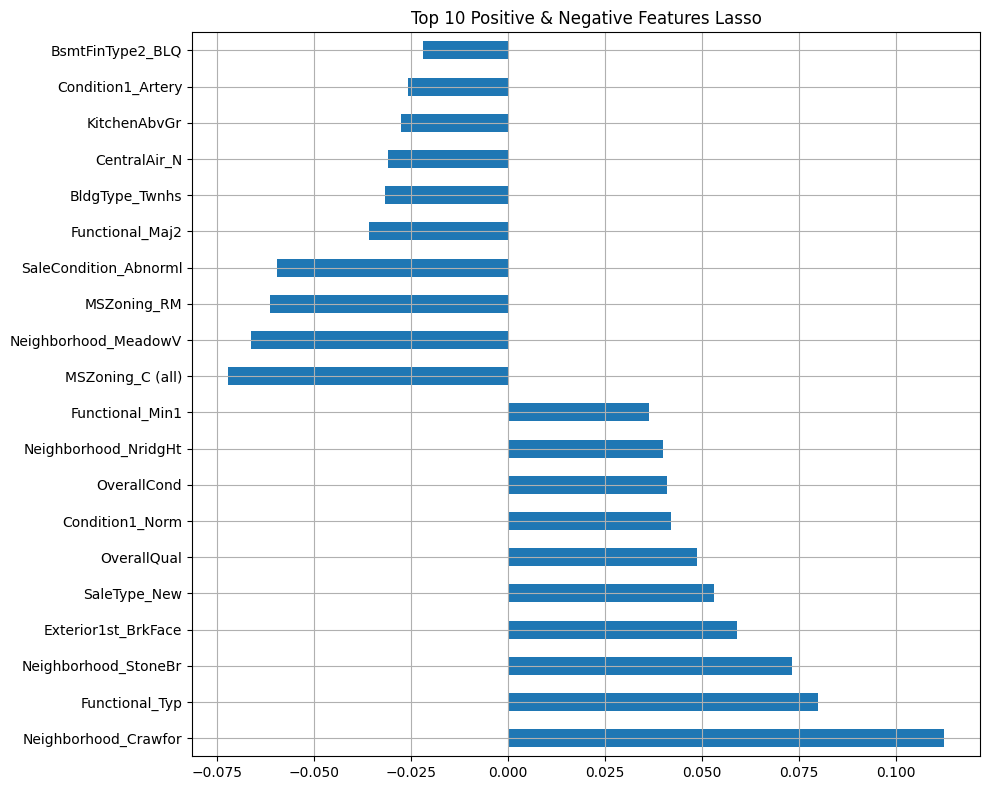

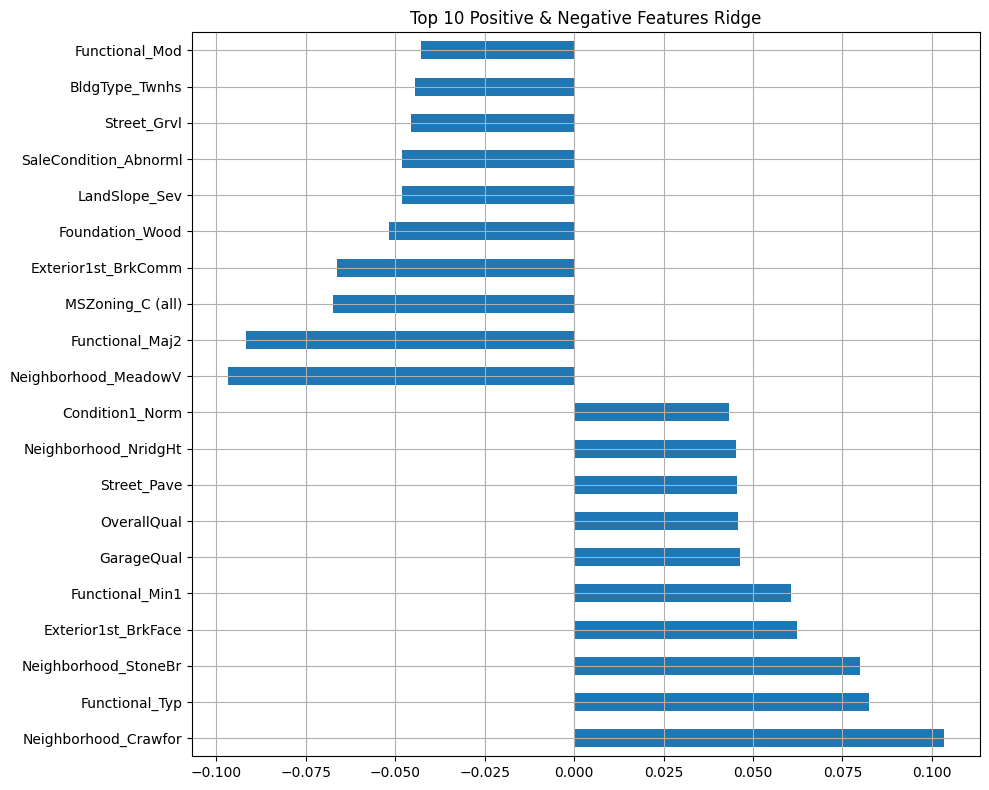

In [ ]:
# 데이터 다시 로드

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv') # Load test data for later

# 이상치 제거

train_df = train_df.drop(train_df[train_df['Id'] == 1299].index)
train_df = train_df.drop(train_df[train_df['Id'] == 524].index)
train_df = train_df.drop(train_df[train_df['Id'] == 31].index)
train_df = train_df.drop(train_df[train_df['Id'] == 496].index)
train_df = train_df.drop(train_df[train_df['Id'] == 917].index)
train_df = train_df.drop(train_df[train_df['Id'] == 524].index)
train_df = train_df.drop(train_df[train_df['Id'] == 1299].index)

# 전처리 함수 설정

def preprocess_data(df, is_train=True):

    # 1. 결측치 채워넣기
    df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
    df['LotFrontage'] = df['LotFrontage'].fillna(df['LotFrontage'].median())

    ## 수치형 컬럼
    numeric_fills_0 = ['MasVnrArea', 'GarageYrBlt', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageCars', 'GarageArea']
    for col in numeric_fills_0:
        if col in df.columns:
            df[col] = df[col].fillna(0)

    ## 범주형 컬럼
    none_cols = ['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
                 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
    for col in none_cols:
        if col in df.columns:
            df[col] = df[col].fillna('None')

    ## 최빈값 대체 컬럼 (Electrical)
    obj_cols = df.select_dtypes(include=['object']).columns
    for col in obj_cols:
        if df[col].isnull().sum() > 0:
            df[col] = df[col].fillna(df[col].mode()[0])

    # 2. 인코딩

    quality_map = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0}
    ordinal_cols = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC',
                    'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']
    for col in ordinal_cols:
        if col in df.columns:
            df[col] = df[col].map(quality_map).fillna(0)

    bsmt_exposure_map = {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'None': 0}
    if 'BsmtExposure' in df.columns:
        df['BsmtExposure'] = df['BsmtExposure'].map(bsmt_exposure_map).fillna(0)

    garage_finish_map = {'Fin': 3, 'RFn': 2, 'Unf': 1, 'None': 0}
    if 'GarageFinish' in df.columns:
        df['GarageFinish'] = df['GarageFinish'].map(garage_finish_map).fillna(0)

    return df

# 데이터프레임에 전처리 함수 적용
train_processed = preprocess_data(train_df.copy(), is_train=True)
test_processed = preprocess_data(test_df.copy(), is_train=False)

# 타겟 변수 로그 변환
train_processed['SalePrice'] = np.log1p(train_processed['SalePrice'])

# 훈련/테스트 데이터 컬럼 조정
y_train_full = train_processed['SalePrice']
X_train_full = train_processed.drop(['SalePrice', 'Id'], axis=1) # Drop Id
X_test_full = test_processed.drop(['Id'], axis=1) # Drop Id


# 모든 데이터에 원-핫인코딩 적용(pd.get_dummies)
all_data = pd.concat([X_train_full, X_test_full])
all_data_dummies = pd.get_dummies(all_data)

X_train_encoded = all_data_dummies.iloc[:len(X_train_full)]
X_test_encoded = all_data_dummies.iloc[len(X_train_full):]


# 최적의 Alpha 계수로 Ridge, Lasso 모델 훈련
lasso_best = Lasso(alpha=0.0005)
lasso_best.fit(X_train_encoded, y_train_full)

Ridge_best = Ridge(alpha=5)
Ridge_best.fit(X_train_encoded, y_train_full)

# XGBoost, LightGBM, RandomForest도 같이 해보기
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate = 0.05, colsample_bytree = 0.5, subsample = 0.8)
xgb_reg.fit(X_train_encoded, y_train_full)

lgbm_reg = LGBMRegressor(n_estimators = 1000, learning_rate = 0.05, num_leaves = 4, subsample = 0.6,
                         colsample_bytree=0.4, reg_lambda = 10, n_jobs = -1, verbosity = -1)
lgbm_reg.fit(X_train_encoded, y_train_full)

rf_reg = RandomForestRegressor(n_estimators = 1000, max_depth = 20,
                               min_samples_split = 2, min_samples_leaf = 2,
                               max_features=0.5, random_state=42, n_jobs=-1)
rf_reg.fit(X_train_encoded, y_train_full)

# 영향력있는 Coefficient 시각화하는 함수 설정
def plot_top_coefs(model, feature_names, top_n=10):
    coefs = pd.Series(model.coef_, index=feature_names)

    coef_high = coefs.sort_values(ascending=False).head(top_n)
    coef_low = coefs.sort_values(ascending=True).head(top_n)

    coef_concat = pd.concat([coef_high, coef_low])

    plt.figure(figsize=(10, 8))
    coef_concat.plot(kind='barh')
    plt.title(f'Top {top_n} Positive & Negative Features {model.__class__.__name__}')
    plt.grid(True)
    plt.tight_layout()

# 규제 적용 모델의 Coefficient 확인
plot_top_coefs(lasso_best, X_train_encoded.columns)
plot_top_coefs(Ridge_best, X_train_encoded.columns)

## 여러 모델로 스태킹 앙상블 기법 시도

- 앞서 말했듯이 Ridge를 제외한 모든 모델을 스태킹 (대부분의 경우의수에서 가장 높은 점수 기록)

- 단일 모델만의 한계를 극복해 조금 더 상향된 점수를 얻을 수 있다

- 모델 개별간 예측값 상관관계가 낮을 수록 좋다.

- 교재 코드를 참고했습니다.

### 스태킹 모델 검증

In [ ]:
# 스태킹 모델 검증 함수
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):

  # K-Fold 방식 구현
  kf = KFold(n_splits = n_folds, shuffle=False)

  train_fold_pred = np.zeros((X_train_n.shape[0], 1))
  test_pred = np.zeros((X_test_n.shape[0], n_folds))

  print(model.__class__.__name__, ' model 시작')

  for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):

    print('\t 폴드 세트: ', folder_counter, ' 시작')

    X_tr = X_train_n[train_index]
    y_tr = y_train_n[train_index]
    X_te = X_train_n[valid_index]

    model.fit(X_tr, y_tr)
    train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1, 1)
    test_pred[:, folder_counter] = model.predict(X_test_n)

  test_pred_mean = np.mean(test_pred, axis=1).reshape(-1, 1)

  return train_fold_pred, test_pred_mean    # 각 폴드 당 훈련 점수/예측 평균 반환


X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 5)
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, X_train_n, y_train_n, X_test_n, 5)
rf_train, rf_test = get_stacking_base_datasets(rf_reg, X_train_n, y_train_n, X_test_n, 5)

Stack_final_X_train = np.concatenate((rf_train, lasso_train, xgb_train, lgbm_train), axis = 1)
Stack_final_X_test = np.concatenate((rf_test, lasso_test, xgb_test, lgbm_test), axis = 1)

meta_model_lasso = Lasso(alpha = 0.0005)

meta_model_lasso.fit(Stack_final_X_train, y_train)
final = meta_model_lasso.predict(Stack_final_X_test)

mse = mean_squared_error(y_test, final)
rmse = np.sqrt(mse)
print(f'스태킹 회귀 모델 검증 RMSE : {rmse:4f}')

Lasso  model 시작
	 폴드 세트:  0  시작
	 폴드 세트:  1  시작
	 폴드 세트:  2  시작
	 폴드 세트:  3  시작
	 폴드 세트:  4  시작
XGBRegressor  model 시작
	 폴드 세트:  0  시작
	 폴드 세트:  1  시작
	 폴드 세트:  2  시작
	 폴드 세트:  3  시작
	 폴드 세트:  4  시작
LGBMRegressor  model 시작
	 폴드 세트:  0  시작
	 폴드 세트:  1  시작
	 폴드 세트:  2  시작
	 폴드 세트:  3  시작
	 폴드 세트:  4  시작
RandomForestRegressor  model 시작
	 폴드 세트:  0  시작
	 폴드 세트:  1  시작
	 폴드 세트:  2  시작
	 폴드 세트:  3  시작
	 폴드 세트:  4  시작
스태킹 회귀 모델 검증 RMSE : 0.106489


## 최종 스태킹 모델 적용 및 Submission

In [ ]:
# Submission용 테스트 데이터를 일치시키기 위해 스태킹 함수 변형
def get_stacking_base_datasets(model, X_train_full_data, y_train_full_data, X_test_submission_data, n_folds):
    kf = KFold(n_splits=n_folds, shuffle = True, random_state=42)

    train_fold_pred = np.zeros((X_train_full_data.shape[0], 1))

    test_pred_folds = np.zeros((X_test_submission_data.shape[0], n_folds))

    print(model.__class__.__name__, ' model 시작')

    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_full_data, y_train_full_data)):
        print('\t 폴드 세트: ', folder_counter, ' 시작')

        X_tr = X_train_full_data[train_index]
        y_tr = y_train_full_data[train_index]
        X_val = X_train_full_data[valid_index]

        model.fit(X_tr, y_tr)
        # 메타 모델을 위한 검증 세트로 OOB 예측
        train_fold_pred[valid_index, :] = model.predict(X_val).reshape(-1, 1)
        # 실제 테스트 데이터 예측
        test_pred_folds[:, folder_counter] = model.predict(X_test_submission_data)

    test_pred_mean = np.mean(test_pred_folds, axis=1).reshape(-1, 1)

    return train_fold_pred, test_pred_mean


X_train_data_np = X_train_encoded.values
y_train_data_np = y_train_full.values
X_test_submission_data_np = X_test_encoded.values
test_ids = test_df['Id']

print(f"학습 데이터 형태 (Stacking input): {X_train_data_np.shape}")
print(f"제출용 테스트 데이터 형태 (Stacking input): {X_test_submission_data_np.shape}")
print("Stacking models processing...")


lasso_train_meta, lasso_test_meta = get_stacking_base_datasets(lasso_reg, X_train_data_np, y_train_data_np, X_test_submission_data_np, 5)
xgb_train_meta, xgb_test_meta = get_stacking_base_datasets(xgb_reg, X_train_data_np, y_train_data_np, X_test_submission_data_np, 5)
lgbm_train_meta, lgbm_test_meta = get_stacking_base_datasets(lgbm_reg, X_train_data_np, y_train_data_np, X_test_submission_data_np, 5)
rf_train_meta, rf_test_meta = get_stacking_base_datasets(rf_reg, X_train_data_np, y_train_data_np, X_test_submission_data_np, 5)


# 메타 모델을 위한 데이터 합치기 (Concatenate the out-of-fold predictions for training)
Stack_final_X_train = np.concatenate((lasso_train_meta, xgb_train_meta, lgbm_train_meta, rf_train_meta), axis=1)
# 메타 모델을 위한 테스트 데이터 합치기 (Concatenate predictions on the actual test set)
Stack_final_X_test = np.concatenate((lasso_test_meta, xgb_test_meta, lgbm_test_meta, rf_test_meta), axis=1)

# 메타 모델 학습 및 예측
meta_model_lasso = Lasso(alpha=0.0005, random_state=42) # Use the tuned alpha and add random_state
meta_model_lasso.fit(Stack_final_X_train, y_train_full) # Train meta-model on out-of-fold predictions and full training target

# 최종 예측 (로그 스케일) -> 원래 가격으로 복원
final_pred_log = meta_model_lasso.predict(Stack_final_X_test)
final_pred_original = np.expm1(final_pred_log)

submission = pd.DataFrame({
    'Id': test_ids,
    'SalePrice': final_pred_original
})

submission.to_csv('submission_stacking.csv', index=False)
print("제출 파일 생성 완료! submission_stacking.csv")

학습 데이터 형태 (Stacking input): (1163, 254)
제출용 테스트 데이터 형태 (Stacking input): (292, 254)
Stacking models processing...
Lasso  model 시작
	 폴드 세트:  0  시작
	 폴드 세트:  1  시작
	 폴드 세트:  2  시작
	 폴드 세트:  3  시작
	 폴드 세트:  4  시작
XGBRegressor  model 시작
	 폴드 세트:  0  시작
	 폴드 세트:  1  시작
	 폴드 세트:  2  시작
	 폴드 세트:  3  시작
	 폴드 세트:  4  시작
LGBMRegressor  model 시작
	 폴드 세트:  0  시작
	 폴드 세트:  1  시작
	 폴드 세트:  2  시작
	 폴드 세트:  3  시작
	 폴드 세트:  4  시작
RandomForestRegressor  model 시작
	 폴드 세트:  0  시작
	 폴드 세트:  1  시작
	 폴드 세트:  2  시작
	 폴드 세트:  3  시작
	 폴드 세트:  4  시작
제출 파일 생성 완료! submission_stacking.csv
